In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d almightyj/person-face-sketches

Dataset URL: https://www.kaggle.com/datasets/almightyj/person-face-sketches
License(s): CC0-1.0
 99% 1.27G/1.29G [00:05<00:00, 222MB/s]
100% 1.29G/1.29G [00:05<00:00, 261MB/s]


In [3]:
!unzip person-face-sketches.zip -d dataset/

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/sketches/6061.jpg  
  inflating: dataset/train/sketches/6062.jpg  
  inflating: dataset/train/sketches/6063.jpg  
  inflating: dataset/train/sketches/6064.jpg  
  inflating: dataset/train/sketches/6065.jpg  
  inflating: dataset/train/sketches/6066.jpg  
  inflating: dataset/train/sketches/6067.jpg  
  inflating: dataset/train/sketches/6068.jpg  
  inflating: dataset/train/sketches/6069.jpg  
  inflating: dataset/train/sketches/607.jpg  
  inflating: dataset/train/sketches/6070.jpg  
  inflating: dataset/train/sketches/6071.jpg  
  inflating: dataset/train/sketches/6072.jpg  
  inflating: dataset/train/sketches/6073.jpg  
  inflating: dataset/train/sketches/6074.jpg  
  inflating: dataset/train/sketches/6075.jpg  
  inflating: dataset/train/sketches/6076.jpg  
  inflating: dataset/train/sketches/6077.jpg  
  inflating: dataset/train/sketches/6078.jpg  
  inflating: dataset/train/sketches/6079.jpg  
  inflatin

In [14]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class FaceSketchDataset(Dataset):
    def __init__(self, sketch_dir, real_dir, transform=None):
        self.sketch_dir = sketch_dir
        self.real_dir = real_dir
        self.transform = transform
        self.sketches = os.listdir(self.sketch_dir)
        self.reals = os.listdir(self.real_dir)

    def __len__(self):
        return len(self.sketches)

    def __getitem__(self, idx):
        sketch_path = os.path.join(self.sketch_dir, self.sketches[idx])
        real_path = os.path.join(self.real_dir, self.reals[idx])

        sketch = Image.open(sketch_path).convert('L')  # grayscale
        real = Image.open(real_path).convert('RGB')  # real image in color

        if self.transform:
            sketch = self.transform(sketch)
            real = self.transform(real)

        return sketch, real

# Transform for preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Load dataset
sketch_dir = 'dataset/train/sketches'
real_dir = 'dataset/train/photos'
dataset = FaceSketchDataset(sketch_dir, real_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [5]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            # Input: sketch + noise (1 channel), output: generated image (3 channels)
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # Downsample
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Upsample
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output to [-1, 1] range
        )

    def forward(self, x):
        return self.model(x)


In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=4, stride=2, padding=1),  # Input: sketch + real/generated image
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1),  # Final layer outputting 1 channel
            nn.Sigmoid()  # Sigmoid to get probability
        )

    def forward(self, sketch, img):
        x = torch.cat([sketch, img], dim=1)  # Concatenate along the channel axis
        return self.model(x)


In [11]:
import torch.optim as optim

criterion_gan = nn.BCELoss()  # Adversarial loss
criterion_l1 = nn.L1Loss()    # L1 loss for pixel-wise difference

lr = 0.0002

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


In [8]:
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
import os
import torch
import matplotlib.pyplot as plt

# Mount Google Drive (only necessary if running on Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define the path for saving checkpoints
checkpoint_dir = '/content/drive/MyDrive/cgan_checkpoints/'
os.makedirs(checkpoint_dir, exist_ok=True)

# Function to save model checkpoints
def save_checkpoint(generator, discriminator, optimizer_g, optimizer_d, epoch, loss_g, loss_d):
    checkpoint = {
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_g_state_dict': optimizer_g.state_dict(),
        'optimizer_d_state_dict': optimizer_d.state_dict(),
        'loss_g': loss_g,
        'loss_d': loss_d
    }
    torch.save(checkpoint, os.path.join(checkpoint_dir, f'cgan_checkpoint_epoch_{epoch}.pth'))
    print(f'Checkpoint saved for epoch {epoch}')

# Function to load the latest checkpoint automatically
def get_latest_checkpoint(checkpoint_dir):
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]
    if len(checkpoints) == 0:
        return None
    checkpoints.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))  # Sort by epoch number
    latest_checkpoint = checkpoints[-1]
    return os.path.join(checkpoint_dir, latest_checkpoint)

# Function to load model checkpoints
def load_checkpoint(generator, discriminator, optimizer_g, optimizer_d, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizer_g.load_state_dict(checkpoint['optimizer_g_state_dict'])
    optimizer_d.load_state_dict(checkpoint['optimizer_d_state_dict'])
    epoch = checkpoint['epoch']
    loss_g = checkpoint['loss_g']
    loss_d = checkpoint['loss_d']
    print(f'Checkpoint loaded: epoch {epoch}, loss_g: {loss_g}, loss_d: {loss_d}')
    return epoch, loss_g, loss_d

# Function to display images with de-normalization
def denormalize(tensor):
    return tensor * 0.5 + 0.5  # Inverse of normalization

# Function to display images
def display_images(real_images, fake_images, num_images=5):

    real_images = denormalize(real_images).detach().cpu().numpy()
    fake_images = denormalize(fake_images).detach().cpu().numpy()

    fig, axs = plt.subplots(2, num_images, figsize=(15, 6))

    for i in range(num_images):
        # Display real images
        axs[0, i].imshow(real_images[i].transpose(1, 2, 0))
        axs[0, i].axis('off')
        axs[0, i].set_title('Real')

        # Display fake images
        axs[1, i].imshow(fake_images[i].transpose(1, 2, 0))
        axs[1, i].axis('off')
        axs[1, i].set_title('Fake')

    plt.show()

# Training loop with checkpointing and resume functionality
num_epochs = 3

# Load the latest checkpoint (if exists)
latest_checkpoint_path = get_latest_checkpoint(checkpoint_dir)
if latest_checkpoint_path:
    start_epoch, loss_g, loss_d = load_checkpoint(generator, discriminator, optimizer_g, optimizer_d, latest_checkpoint_path)
    print(f"Resuming from epoch {start_epoch + 1}")
else:
    start_epoch = 0
    print("No checkpoint found, starting from scratch.")

for epoch in range(start_epoch, num_epochs):
    for i, (sketches, reals) in enumerate(dataloader):

        dummy_output = discriminator(sketches[:1], reals[:1])
        output_shape = dummy_output.shape

        # Create labels
        real_labels = torch.ones(reals.size(0), *output_shape[1:])
        fake_labels = torch.zeros(reals.size(0), *output_shape[1:])

        # Train Discriminator
        optimizer_d.zero_grad()

        # Real images
        real_outputs = discriminator(sketches, reals)
        real_loss = criterion_gan(real_outputs, real_labels)

        # Fake images
        fake_images = generator(sketches)
        fake_outputs = discriminator(sketches, fake_images.detach())  # Detach to avoid gradient updates in generator
        fake_loss = criterion_gan(fake_outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()

        fake_outputs = discriminator(sketches, fake_images)
        g_loss_gan = criterion_gan(fake_outputs, real_labels)
        g_loss_l1 = criterion_l1(fake_images, reals)

        g_loss = g_loss_gan + 100 * g_loss_l1  # Weighted L1 loss
        g_loss.backward()
        optimizer_g.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

        # Display images at a certain interval
        if i % 5 == 0:  # Display every 100 steps or adjust as needed
            display_images(reals, fake_images)

    # Save checkpoint after every epoch
    save_checkpoint(generator, discriminator, optimizer_g, optimizer_d, epoch, g_loss.item(), d_loss.item())


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
generator.to(device)

Generator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

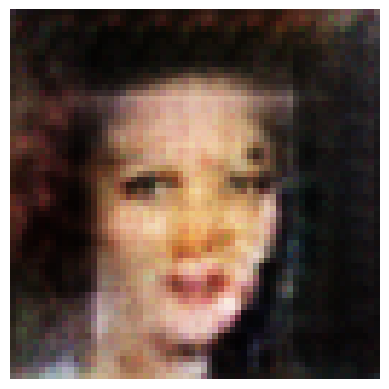

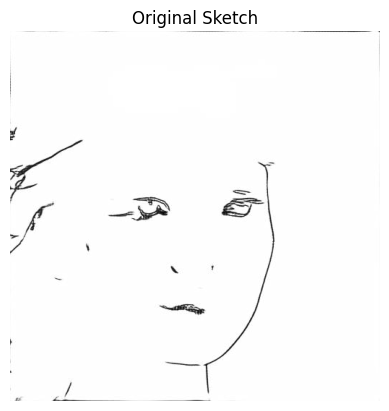

In [36]:
import torch
from PIL import Image
import torchvision.transforms as transforms

# Function to load and preprocess the sketch
def load_sketch(sketch_path, img_size=(64, 64)):
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1] range
    ])

    sketch = Image.open(sketch_path).convert('L')  # grayscale
    sketch = transform(sketch).unsqueeze(0)  # Add batch dimension
    return sketch

# Function to generate and display the image from a sketch
def generate_image_from_sketch(generator, sketch_path):
    # Load the sketch and preprocess
    sketch = load_sketch(sketch_path)

    # Move to device (GPU or CPU)
    sketch = sketch.to(device)

    # Generate the fake image
    generator.eval()  # Set generator to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        fake_image = generator(sketch)

    # Denormalize the image to bring it back to [0, 1] range
    fake_image = denormalize(fake_image.squeeze(0))  # Remove batch dimension
    fake_image = fake_image.cpu().numpy().transpose(1, 2, 0)  # Convert to numpy array

    # Display the generated image
    plt.imshow(fake_image)
    plt.axis('off')
    plt.show()



# Path to the sketch
sketch_path = '/content/dataset/test/sketches/987.jpg'

# Generate and display the image
generate_image_from_sketch(generator, sketch_path)

# Load and convert the sketch to grayscale
original_sketch = Image.open(sketch_path).convert('L')  # Load as grayscale

# Convert the image to a numpy array and normalize to [0, 1] for display
original_sketch = np.array(original_sketch) / 255.0

# Display the sketch
plt.imshow(original_sketch, cmap='gray')
plt.axis('off')  # Turn off axis
plt.title('Original Sketch')
plt.show()